# Overview

The dataset employed in this context comprises of energy consumption readings in kilowatt-hour (kWh) collected from a sample of London households during the period between November 2011 and February 2014 from [SmartMeter Energy Consumption Data in London Households](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households). This time-series data, inherently structured around precise timestamps, possesses the potential to reveal invaluable insights into the patterns and trends of energy usage over time.

Upon loading the dataset, we carry out preliminary exploratory data analysis, including plotting and assessing the data structure, range, and potential missing values. Further, we refine the dataset to focus on the 'DateTime' and 'kWh' columns exclusively, as they encapsulate the essence of our data analysis.

The subsequent step includes manipulating the data, converting the 'DateTime' column to a day of year format and 'kWh' to a numeric type, to facilitate the creation of pivot tables and hierarchical clustering dendrograms. Following this, we employ Prophet and LSTM models to enhance the accuracy of our time-series forecasting.

Overall, this process is geared towards understanding the energy consumption patterns, forecasting future usage, and potentially uncovering insights that could contribute to more efficient and sustainable energy management strategies.



 
## 1. Loading and Handling Time Series

The code provided loads the dataset, which is a CSV file named "LCL-June2015v2_1.csv" downloaded from  [SmartMeter Energy Consumption Data in London Households](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households), using the load_data() function. The dataset contains energy consumption data for a specific period. Next, the code converts the 'DateTime' column to the pandas datetime format to facilitate time series analysis. The column name 'KWH/hh (per half hour) ' is then renamed to 'kWh' for easier access.



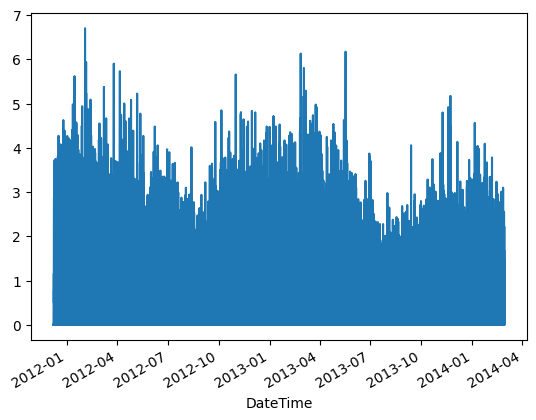

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data():
    raw_data = pd.read_csv("LCL-June2015v2_1.csv", header=0)
    return raw_data

data_frame = load_data()

data_frame['DateTime'] = pd.to_datetime(data_frame['DateTime'])

# renaming the column for easy access
data_frame.rename(columns={'KWH/hh (per half hour) ': 'kWh'}, inplace=True)

# Setting DateTime as the index
time_series_data = data_frame.set_index('DateTime')

# Converting kWh to numeric, if there are errors coerce them
time_series_data['kWh'] = pd.to_numeric(time_series_data['kWh'], downcast='float', errors='coerce')

# Plotting the data
time_series_data['kWh'].plot()
plt.show()

## 2. Exploratory Data Analysis (EDA)

The first plot visualizes the energy consumption over time, with the 'DateTime' on the x-axis and 'kWh' on the y-axis. This line plot provides an overview of the overall consumption pattern.


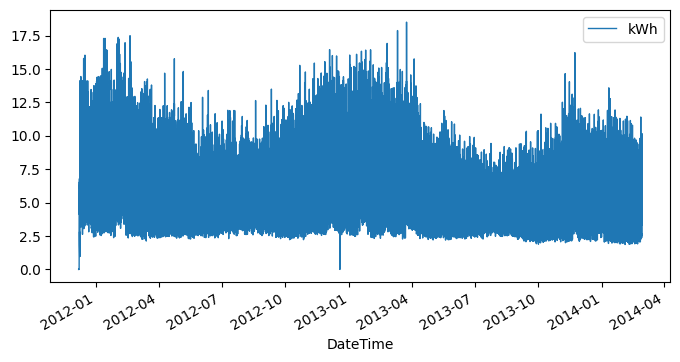

In [3]:
import seaborn as sns

# renaming the column for easy access
df = data_frame.loc[:, ['DateTime', 'kWh']]
df['kWh'] = pd.to_numeric(df['kWh'], errors='coerce')
df = df.groupby(['DateTime']).sum().reset_index()

df.plot.line(x = 'DateTime', y = 'kWh', figsize=(8,4), linewidth=1, fontsize=10)
plt.show()

Extracting the month from the 'DateTime' column and creates a scatter plot to analyze the relationship between energy consumption and months. This allows for the identification of any seasonal patterns.

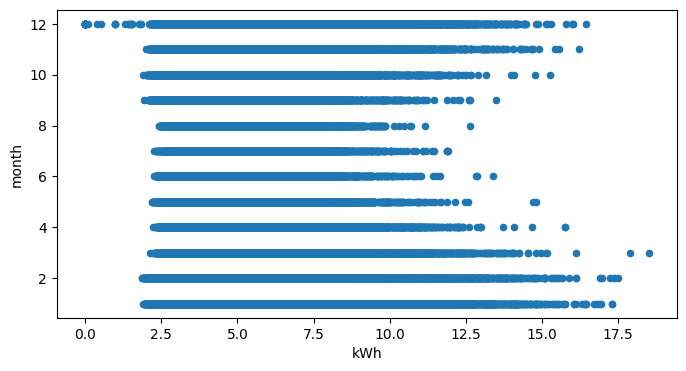

In [4]:
# Extracting month from DateTime and creating a new dataframe for the scatter plot
df['month'] = df['DateTime'].dt.month
scatter_plot_data = df.drop(['DateTime'], axis = 1)

scatter_plot_data.plot.scatter(x = 'kWh', y = 'month', figsize=(8,4), linewidth=1, fontsize=10)
plt.show()


Trend analysis using a rolling window, seasonal variation analysis with a 30-period difference

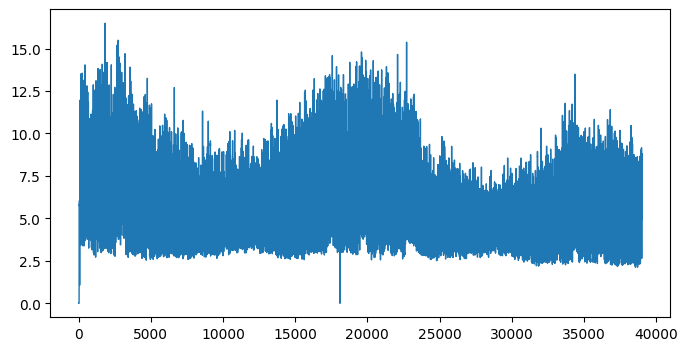

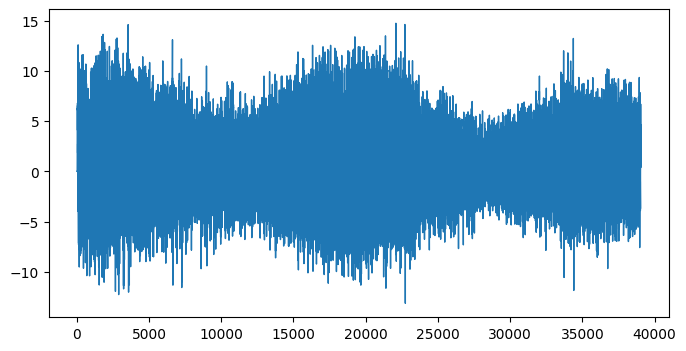

In [5]:
# Trend analysis using a rolling window
df['kWh'].rolling(5).mean().plot(figsize=(8,4), linewidth=1, fontsize=10)
plt.show()

# Seasonal variation analysis with a 30-period difference
df['kWh'].diff(periods=30).plot(figsize=(8,4), linewidth=1, fontsize=10)
plt.show()

Auto-correlation plot to explore dependencies within the time series data

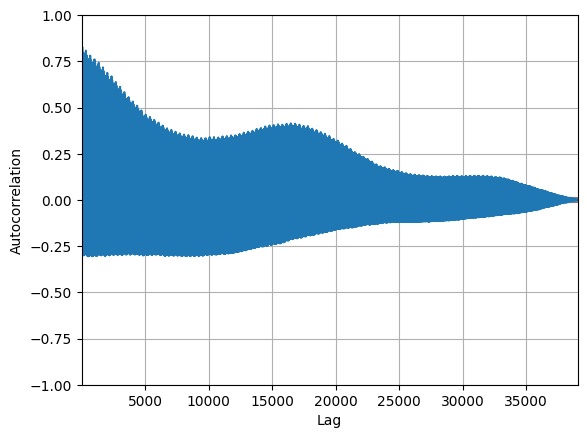

In [6]:
# Auto-correlation plot
pd.plotting.autocorrelation_plot(df['kWh'])
plt.show()

Histogram to examine the distribution of kWh values

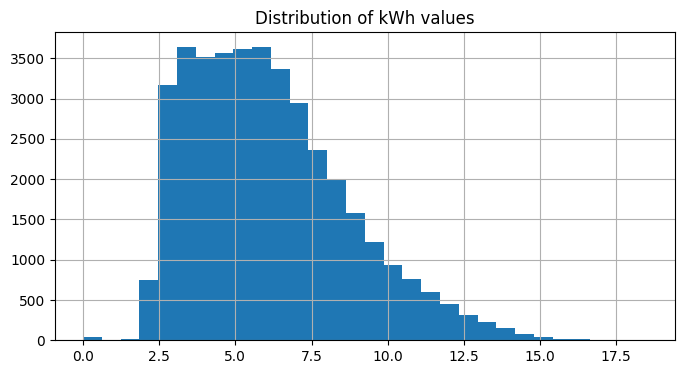

In [7]:
# Histogram of kWh values
df['kWh'].hist(bins=30, figsize=(8,4))
plt.title('Distribution of kWh values')
plt.show()


boxplot to identify potential outliers

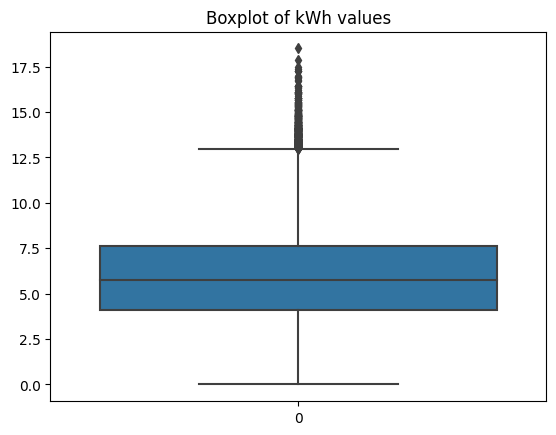

In [8]:
# Boxplot of kWh values
sns.boxplot(df['kWh'])
plt.title('Boxplot of kWh values')
plt.show()

Heatmap of the correlation matrix to understand the relationships between variables

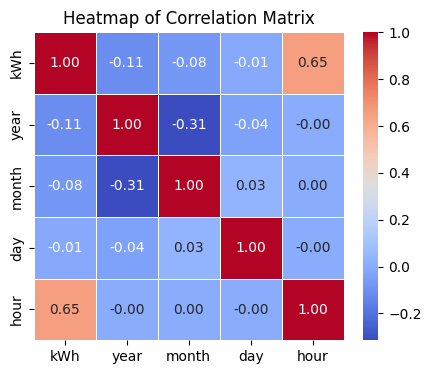

In [9]:
# Decompose DateTime column into separate components
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['hour'] = df['DateTime'].dt.hour

# Calculate correlation matrix
corr = df[['kWh', 'year', 'month', 'day', 'hour']].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()


Visualization of yearly and weekly kWh usage trends. The yearly trend plot showcases the total energy consumption per year, while the weekly trend plot illustrates the weekly energy consumption pattern

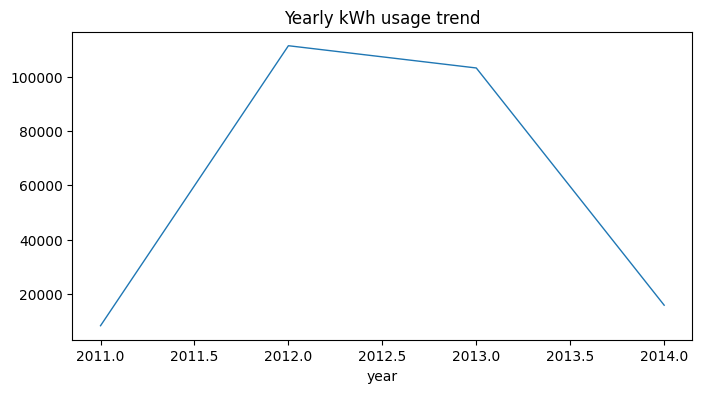

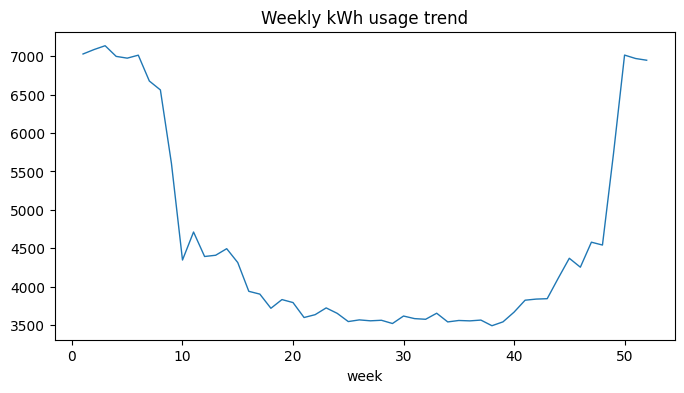

In [10]:
# Yearly kWh usage trend
df['year'] = df['DateTime'].dt.year
df.groupby('year')['kWh'].sum().plot(figsize=((8,4)), linewidth=1, fontsize=10)
plt.title('Yearly kWh usage trend')
plt.show()

# Weekly kWh usage trend
df['week'] = df['DateTime'].dt.isocalendar().week
df.groupby('week')['kWh'].sum().plot(figsize=(8,4), linewidth=1, fontsize=10)
plt.title('Weekly kWh usage trend')
plt.show()

## 3. Resampling Time Series Data Using Pandas

The data is resampled on a weekly basis using the 'W' frequency, and the sum of energy consumption is computed for each week. Linear interpolation is then applied to fill in any missing values, and the resampled data is plotted to visualize the weekly consumption trends

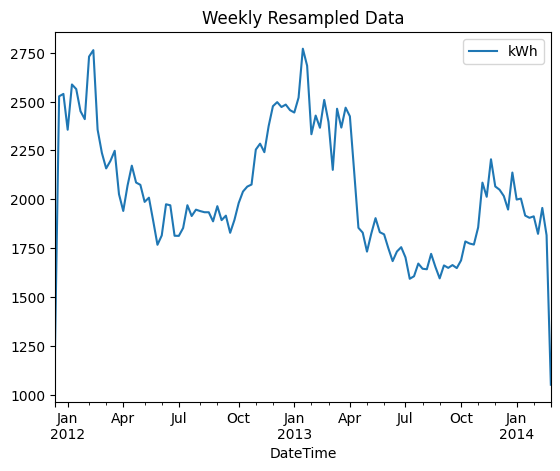

In [11]:
# Weekly resampling
weekly_resampled_data = time_series_data.resample('W').sum()
weekly_resampled_data.interpolate(method='linear', inplace=True)
weekly_resampled_data.plot()
plt.title("Weekly Resampled Data")
plt.show()

The data is resampled on a daily basis using the 'D' frequency, and again, the sum of energy consumption is calculated for each day. Linear interpolation is employed to handle any missing values, and a rolling window of 30 days is applied to visualize the daily consumption trend with a smoothed curve.

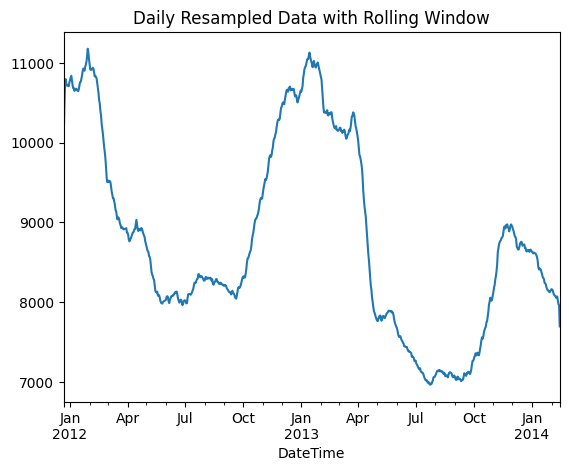

In [12]:
# Daily resampling with rolling window
daily_resampled_data = time_series_data['kWh'].resample('D').sum()

# Interpolate
daily_resampled_data.interpolate(method='linear', inplace=True)

# Rolling window operation
rolling_data = daily_resampled_data.rolling(30, center=True).sum()

# Handling NaN values (if any)
rolling_data = rolling_data.dropna()

# Plotting the data
rolling_data.plot()
plt.title("Daily Resampled Data with Rolling Window")
plt.show()


The data is grouped by the time of the day. The mean usage for each time interval is computed, and the plot showcases the average energy consumption by time of day. The x-axis is labeled with hourly ticks to indicate the time intervals

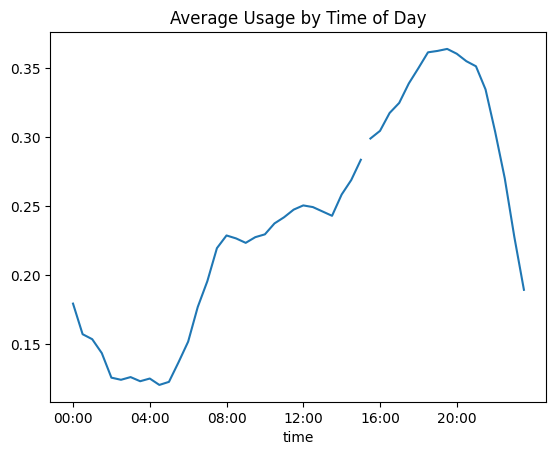

In [13]:
# Group by time of the day
by_time_of_day = time_series_data['kWh'].groupby(time_series_data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time_of_day.plot(xticks=hourly_ticks)
plt.title("Average Usage by Time of Day")
plt.show()


## 4. Hierarchical Clustering
Clustering for Time Series Data: The application of clustering in time-series data is valuable because it allows us to identify patterns over time. For example, we might find that energy consumption forms distinct clusters based on the hour of the day or day of the year. This type of analysis can reveal important patterns, like peaks in usage during certain times or on certain days.



- Load and clean the dataset, converting the 'DateTime' column to a datetime format.
- Extract the day of the year and hour of the day from the 'DateTime' column for clustering.
- Pivot the data to reshape it for better visualization and clustering.
- Display and plot the reshaped data, showing the hourly energy consumption throughout the year.

day_of_year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
hour_of_day,,,,,,,,,,,,,,,,,,,,,
0,0.245916,0.209383,0.202955,0.183175,0.209643,0.213643,0.174305,0.180260,0.156506,0.164584,...,0.225409,0.243052,0.251734,0.268701,0.255065,0.233989,0.222968,0.168727,0.210994,0.231333
1,0.222097,0.179682,0.164039,0.181916,0.174773,0.171500,0.158864,0.157143,0.137338,0.153825,...,0.174474,0.172656,0.174565,0.203740,0.168799,0.170591,0.157779,0.143494,0.155610,0.199704
2,0.174136,0.132481,0.131513,0.138188,0.134608,0.137753,0.119448,0.124649,0.114558,0.115169,...,0.136383,0.144318,0.145383,0.147623,0.132591,0.142734,0.141182,0.117708,0.131409,0.145815
3,0.153773,0.135136,0.141006,0.109117,0.138974,0.122740,0.125805,0.121481,0.112416,0.105883,...,0.120487,0.141390,0.129844,0.131766,0.129851,0.133286,0.125974,0.121591,0.133981,0.138852
4,0.140117,0.138000,0.134344,0.123506,0.126734,0.122085,0.125851,0.130623,0.115318,0.126831,...,0.123682,0.138396,0.126961,0.130532,0.126006,0.128130,0.121734,0.110870,0.109695,0.152667


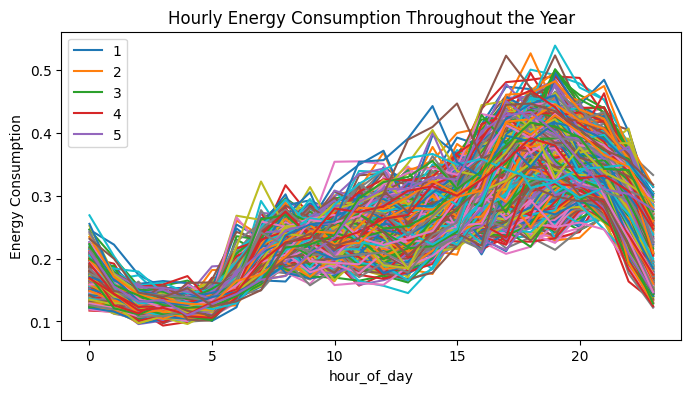

In [14]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Load and clean data
data_frame['date'] = pd.to_datetime(data_frame['DateTime'])

# Checking for any missing values
if data_frame.isnull().values.any():
    print("Warning: Missing data found. Filling with zeroes...")
    data_frame.fillna(0, inplace=True)

# Extract day of the year and hour of the day for clustering
data_frame['day_of_year'] = data_frame['date'].dt.dayofyear
data_frame['hour_of_day'] = data_frame['date'].dt.hour

# Select relevant columns and convert energy consumption to numeric
energy_data = data_frame[['hour_of_day', 'day_of_year', 'kWh']].copy()
energy_data['kWh'] = pd.to_numeric(energy_data['kWh'], errors='coerce')

# Pivot the data for better visualization and clustering
pivot_data = energy_data.pivot_table(index='hour_of_day', columns='day_of_year', values='kWh', fill_value=0)

# Display and plot the reshaped data
display(pivot_data.head())
# Plotting code
ax = pivot_data.plot(figsize=(8, 4), title="Hourly Energy Consumption Throughout the Year")

# Get the legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Show only the first 5 items in the legend
ax.legend(handles[:5], labels[:5])

# Set y-axis label
ax.set_ylabel("Energy Consumption")

# Display the plot
plt.show()



- Perform hierarchical clustering using the 'ward' method.
- Plot the full hierarchical clustering dendrogram.

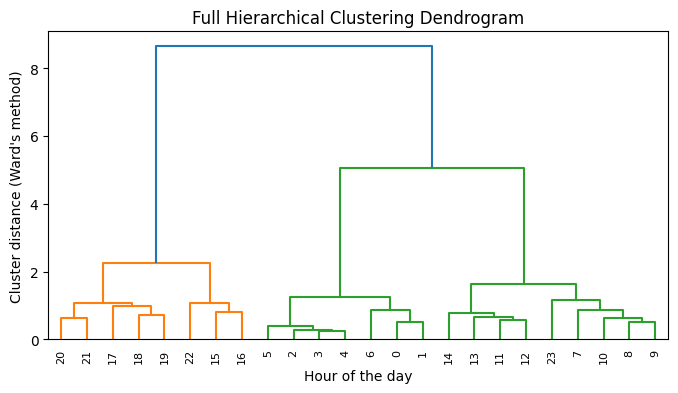

In [15]:
# Hierarchical clustering using the 'ward' method
linkage_matrix = linkage(pivot_data, 'ward')

# Dendrogram plot function
def plot_dendrogram(linkage_matrix, title, truncate=False):
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plt.xlabel('Hour of the day')
    plt.ylabel('Cluster distance (Ward\'s method)')
    if truncate:
        dendrogram(linkage_matrix, truncate_mode='lastp', p=4, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
    else:
        dendrogram(linkage_matrix, leaf_rotation=90., leaf_font_size=8.)
    plt.show()

# Full dendrogram plot
plot_dendrogram(linkage_matrix, title="Full Hierarchical Clustering Dendrogram")

# # Truncated dendrogram plot
# plot_dendrogram(linkage_matrix, title="Truncated Hierarchical Clustering Dendrogram", truncate=True)


# 4. Modeling with Prophet 
Facebook Prophet, released in 2017 for Python and R, is a time series analysis tool. It excels at handling daily observations with patterns on various time scales, tolerates missing data and trend shifts, and effectively handles outliers. Prophet also offers advanced features for modeling holiday effects and implementing custom changepoints. However, for simplicity, I'll focus on the basics to quickly set up a model. Prophet is a suitable choice for producing rapid forecasts due to its intuitive parameters, making it accessible to domain experts with less forecasting model expertise. 

- Import the required packages for data visualization and Prophet modelling.
- Convert the index of the time series data to a datetime format.
- Resample the data to daily frequency by summing the values for each day.

In [16]:
# Import required packages
import matplotlib.pyplot as plt
from prophet import Prophet

# Assuming 'DateTime' is the index of the DataFrame
time_series_data.index = pd.to_datetime(time_series_data.index)

# Resample the data to daily frequency, summing over each day
daily_data = time_series_data.resample('D').sum()

# Reset the index of the DataFrame
daily_data = daily_data.reset_index()

# Renaming dataframe columns to fit the Prophet model's requirement
energy_df = daily_data.reset_index().rename(columns={'DateTime': 'ds', 'kWh': 'y'})

# Display first few records of the modified dataframe
display(energy_df.head())


,index,ds,LCLid,stdorToU,y
0,0,2011-12-07,MAC000037MAC000037MAC000037MAC000037MAC000037M...,StdStdStdStdStdStdStdStdStdStdStdStdStdStdStdStd,0.014000
1,1,2011-12-08,MAC000037MAC000037MAC000037MAC000037MAC000037M...,StdStdStdStdStdStdStdStdStdStdStdStdStdStdStdS...,117.203003
2,2,2011-12-09,MAC000037MAC000038MAC000039MAC000040MAC000041M...,StdStdStdStdStdStdStdStdStdStdStdStdStdStdStdS...,286.204987
3,3,2011-12-10,MAC000037MAC000038MAC000039MAC000040MAC000041M...,StdStdStdStdStdStdStdStdStdStdStdStdStdStdStdS...,391.217010
4,4,2011-12-11,MAC000037MAC000038MAC000039MAC000040MAC000041M...,StdStdStdStdStdStdStdStdStdStdStdStdStdStdStdS...,393.061005


- Initialize a Prophet object with a specified hyperparameter (changepoint_prior_scale).
- Fit the Prophet model to the energy consumption data.

In [17]:
# Initialize a Prophet object. Adjust 'changepoint_prior_scale' for sensitivity of the model's trend to changes 
model = Prophet(changepoint_prior_scale=0.1)

# Fit the model to the data
model.fit(energy_df)


00:43:01 - cmdstanpy - INFO - Chain [1] start processing
00:43:01 - cmdstanpy - INFO - Chain [1] done processing


- Generate a DataFrame with future dates for the next 12 months.
- Use the trained model to make predictions for the future dates.
- Create a figure for plotting the forecast.

<Figure size 1600x600 with 0 Axes>

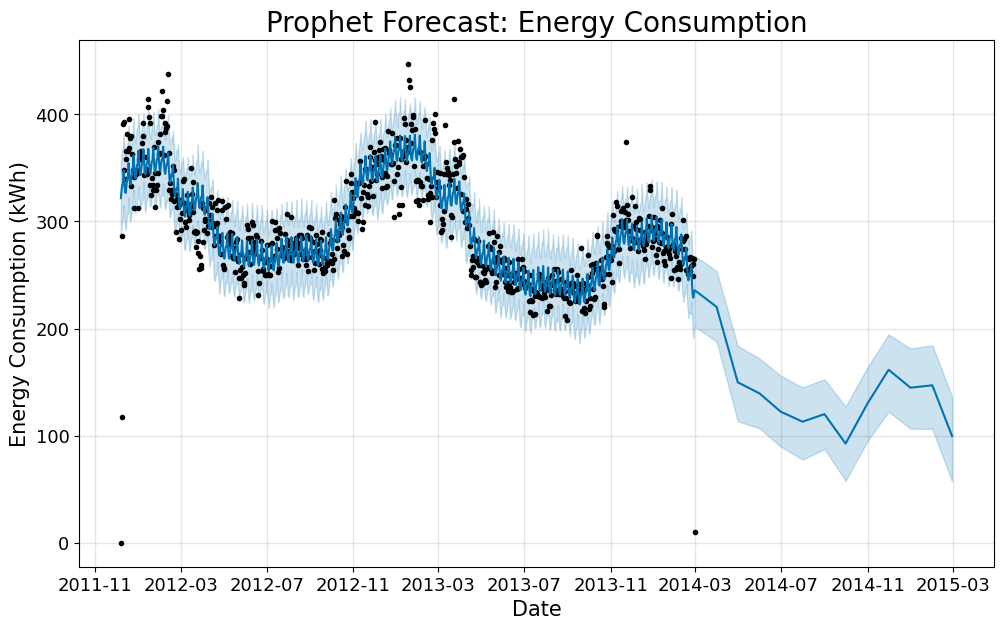

In [18]:
# Generate a dataframe with future dates (for next 12 months)
future = model.make_future_dataframe(periods=12, freq='M')

# Use the model to make predictions
forecast = model.predict(future)

# Create a figure
plt.figure(figsize=(16, 6))

# Use the model's plot method to plot the forecast
model.plot(forecast, xlabel = 'Date', ylabel = 'Energy Consumption (kWh)')

# Add a title to the plot and set its size
plt.title('Prophet Forecast: Energy Consumption', fontsize = 20)

# Adjust label sizes
plt.xlabel('Date', fontsize=15)
plt.ylabel('Energy Consumption (kWh)', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Show the plot
plt.show()


- Plot the forecast components, such as trend, seasonality, and weekly patterns.

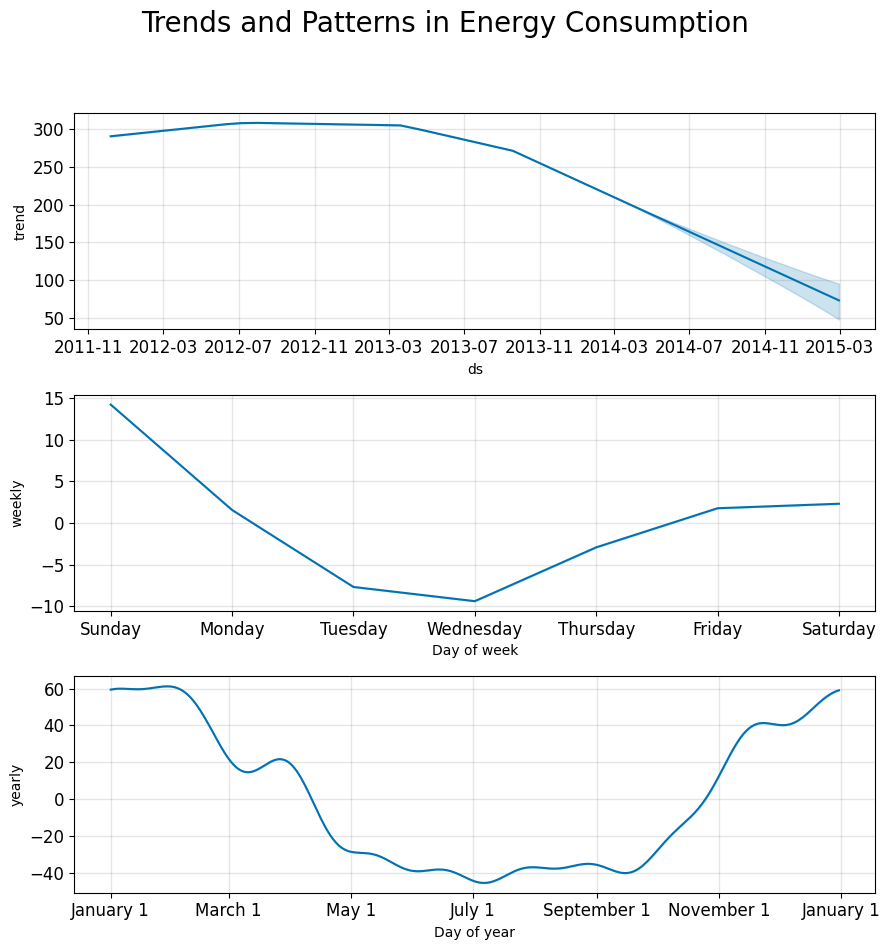

In [19]:
# Plotting the forecast components
components_fig = model.plot_components(forecast)

# Add a super title to the figure
components_fig.suptitle('Trends and Patterns in Energy Consumption', fontsize=20, y=1.05)

# Looping over axes objects to improve plot aesthetics
for ax in components_fig.axes:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

The annual pattern of household energy consumption notably rises during fall and winter, while dipping in spring and summer, as anticipated. A weekly analysis reveals higher consumption on Sundays. Over time, the trend shows a year-long decrease in consumption from 2013. Future exploration will aim to elucidate this trend and determine possible correlations with weather patterns.

## 5. LSTM Prediction 

Long Short-Term Memory (LSTM) recurrent neural networks are a type of artificial neural network designed to learn from sequences of observations, making them particularly suited for time series forecasting. LSTM networks incorporate a unique internal cell architecture which facilitates learning from long sequences without suffering from the "vanishing gradient" problem common in other recurrent networks. This feature enables them to capture patterns over various time scales.

For effective performance, LSTMs require the input data to be normalized, typically within the range of [0, 1] or [-1, 1]. This is because the sigmoid or tanh activation functions used in these networks are sensitive to the input data scale. For time series forecasting, the data is usually split into train and test datasets, with a common split being 80% for training and 20% for testing.


In [20]:
import numpy as np
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from keras_tuner import HyperModel
import matplotlib.pyplot as plt

print(daily_data.columns)

# Rename 'kWh' column and reset index with 'DateTime'
energy_data = daily_data[['kWh']].set_index(daily_data.DateTime)

# Convert 'DateTime' to datetime format
date_values = pd.to_datetime(daily_data['DateTime'])

# Normalize 'kWh' to range [0, 1] using MinMaxScaler
energy_values = energy_data['kWh'].values.reshape(-1, 1).astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(energy_values)

# Splitting data into training set (80%) and testing set (20%)
train_size = int(len(scaled_values) * 0.8)
test_size = len(scaled_values) - train_size
train_values, test_values = scaled_values[0:train_size, :], scaled_values[train_size:]

2023-05-22 00:43:07.593140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Index(['DateTime', 'LCLid', 'stdorToU', 'kWh'], dtype='object')


To prepare the data for modeling, the LSTM network expects input data in a specific array structure: [samples, time steps, features]. In our case, the problem is framed as two time steps for each sample. The network design involves defining a function to create a new dataset that adheres to this structure.


In [21]:
# Function to convert series data to supervised learning data
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the inputs for LSTM [samples, time steps, features]
look_back = 2
trainX, trainY = create_dataset(train_values, look_back)
testX, testY = create_dataset(test_values, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))



A custom hypermodel class for LSTM models and performs hyperparameter tuning using Keras Tuner:

- Define the `LSTMHyperModel` class, which takes the input shape as an argument and builds an LSTM model with tunable hyperparameters.
- The model architecture consists of one or more LSTM layers, with each layer having tunable units, activation function, dropout, and recurrent dropout.
- The model also includes a Dense layer with one output unit.
- Compile the model with the specified loss function, optimizer, and evaluation metric.
- Define the search space for hyperparameter tuning based on the input shape.
- Initialize a random search tuner with a specified objective, maximum number of trials, and project directory.
- Run the hyperparameter search by providing the training and validation data, number of epochs, and verbosity.
- Retrieve the best hyperparameters obtained from the search.
 

In [22]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(LSTM(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
                           activation=hp.Choice('activation_' + str(i), ['tanh', 'relu']),
                           dropout=hp.Float('dropout_' + str(i), 0, 0.5, step=0.1, default=0.2),
                           recurrent_dropout=hp.Float('recurrent_dropout_' + str(i), 0, 0.5, step=0.1, default=0.2),
                           return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False,
                           input_shape=self.input_shape))
        if hp.Int('num_layers', 1, 3) > 1:
            model.add(Flatten())
        model.add(Dense(1))
        model.compile(loss='mean_squared_error',
                      optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
                      metrics=['mean_absolute_error'])
        return model

# Define the search space
input_shape = (trainX.shape[1], trainX.shape[2])
hypermodel = LSTMHyperModel(input_shape)

tuner = kt.RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=20,
    overwrite=True,
    directory='lstm_dir',
    project_name='lstm_tuning'
)

# Run the hyperparameter search
tuner.search(trainX, trainY, epochs=20, validation_data=(testX, testY), verbose=0)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. 
The optimal optimizer is {best_hps.get('optimizer')}.
""")
for i in range(best_hps.get('num_layers')):
    print(f"The optimal number of units in the layer {i} is {best_hps.get('units_' + str(i))}.")
    print(f"The optimal activation in the layer {i} is {best_hps.get('activation_' + str(i))}.")
    print(f"The optimal dropout in the layer {i} is {best_hps.get('dropout_' + str(i))}.")
    print(f"The optimal recurrent_dropout in the layer {i} is {best_hps.get('recurrent_dropout_' + str(i))}.")


2023-05-22 00:44:03.374722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 00:44:03.375907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 00:44:03.377338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
The optimal optimizer is rmsprop.

The optimal number of units in the layer 0 is 160.
The optimal activation in the layer 0 is relu.
The optimal dropout in the layer 0 is 0.0.
The optimal recurrent_dropout in the layer 0 is 0.2.


- Build the LSTM model with the optimal hyperparameters obtained from the hyperparameter search.
- Fit the model to the training data using the best parameters obtained.
- Plot the training and validation loss over the epochs to visualize the model's performance.

Epoch 1/50
11/11 [==============================] - 2s 35ms/step - loss: 0.3883 - mean_absolute_error: 0.6092 - val_loss: 0.2326 - val_mean_absolute_error: 0.4784
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2416 - mean_absolute_error: 0.4785 - val_loss: 0.1390 - val_mean_absolute_error: 0.3694
Epoch 3/50
11/11 [==============================] - 0s 8ms/step - loss: 0.1403 - mean_absolute_error: 0.3597 - val_loss: 0.0664 - val_mean_absolute_error: 0.2533
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0629 - mean_absolute_error: 0.2307 - val_loss: 0.0203 - val_mean_absolute_error: 0.1331
Epoch 5/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0196 - mean_absolute_error: 0.1145 - val_loss: 0.0051 - val_mean_absolute_error: 0.0492
Epoch 6/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_absolute_error: 0.0627 - val_loss: 0.0038 - val_mean_absolute_error: 0.0348
Epoch 7/50
11/11 [=========

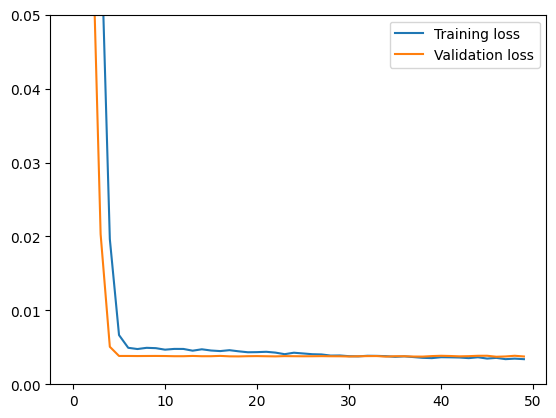

In [23]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)

# Defining batch size
batch_size = 64

# fit the model with the best parameters obtained
history = model.fit(trainX, trainY, epochs=50, batch_size=batch_size, validation_data=(testX, testY), verbose=1, shuffle=False)

# plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylim(0, 0.05)
plt.legend()
plt.show()


- Predicts the output of the train and test sets using the LSTM model.
- Inversely scales the predicted values to their original scale.
- Inversely scales the actual values.
- Shifts the train and test predictions to align them with the original time series data for plotting.
- Converts the date values to match the shape of the full predictions.
- Removes the initial 'look_back' dates and values from the scaled inverse data.
- Plots the graph with date on the x-axis, showing the actual energy consumption, predicted values for the train set, and predicted values for the test set.

6/6 [==============================] - 0s 1ms/step


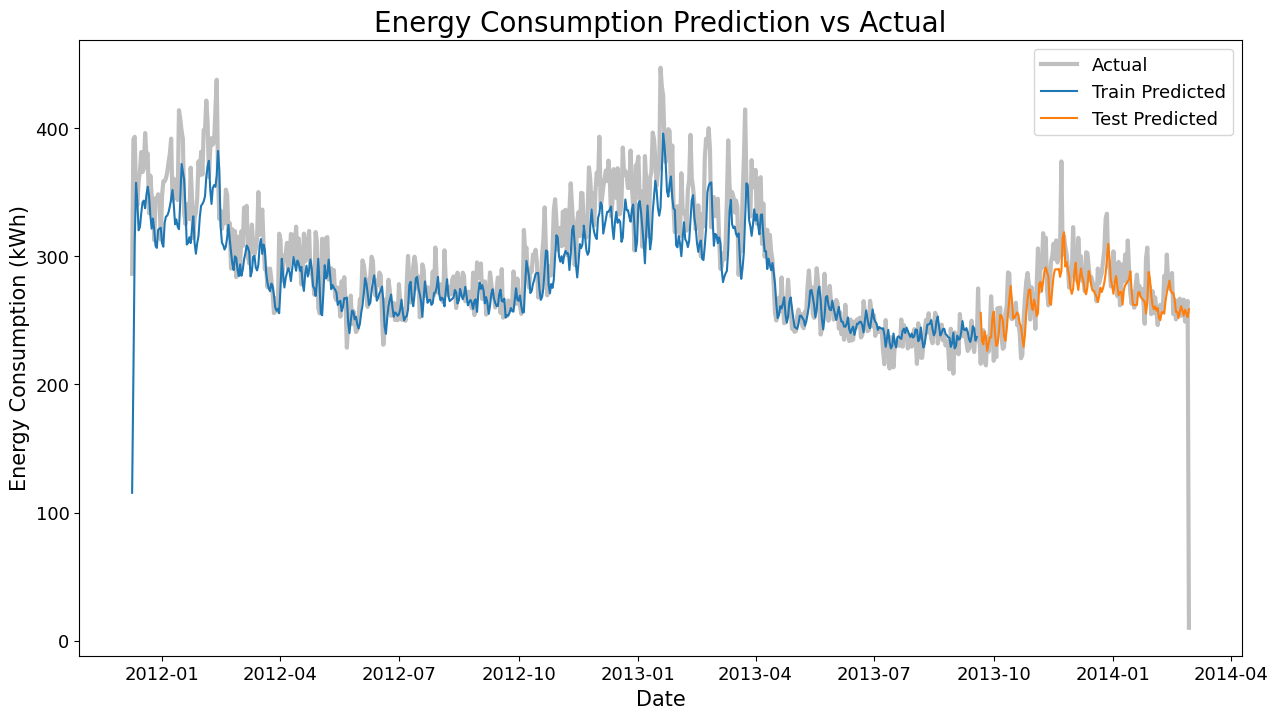

In [24]:
# Predicting the output of the train and test sets
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse scale the predicted values
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Inverse scale the actual values
scaled_inverse = scaler.inverse_transform(scaled_values)

# Shift train and test predictions for plotting
trainPredictPlot = np.empty_like(scaled_inverse)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(scaled_inverse)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(scaled_inverse), :] = testPredict

# Convert date_values to match the shape of fullPredict
# Remove the first 'look_back' dates as they are not included in the predictions due to lag
adjusted_dates = date_values[look_back:]

# Remove the first 'look_back' values from scaled_inverse as they are not included in the predictions due to lag
adjusted_scaled_inverse = scaled_inverse[look_back:]

# Plotting the graph with date on x-axis
plt.figure(figsize=(15, 8))
plt.plot(date_values[look_back:], scaler.inverse_transform(scaled_values)[look_back:], label='Actual', 
         color='grey', linewidth=3, alpha = 0.5)
plt.plot(date_values[look_back:len(trainPredict)+look_back], trainPredict, label='Train Predicted')
plt.plot(date_values[len(trainPredict)+(look_back*2):], testPredict, label='Test Predicted')
plt.title('Energy Consumption Prediction vs Actual', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Energy Consumption (kWh)', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.show()

##### future predictions using the trained LSTM model
It iteratively predicts the next month's energy consumption and appends it to the 'future_predictions' array. The 'future_values' array is updated for each prediction iteration, incorporating the last 'look_back' predictions. Finally, the predicted values in 'future_predictions' are inverse transformed using the scaler to obtain the actual energy consumption values. This process allows for forecasting future energy consumption based on historical data and the LSTM model.

In [29]:
# take last look_back elements from testX
future_values = testX[-1].reshape(1, look_back, 1)

# create an empty array for our future predictions
future_predictions = []

# for each month in the future
for i in range(12):
    # predict the next month
    next_month = model.predict(future_values)
    # append our prediction to future_predictions
    future_predictions.append(next_month[0])
    
    # prepare next future_values using the last look_back predictions
    if len(future_predictions) < look_back:
        future_values = np.concatenate((future_values[0, 1:, :], np.array(future_predictions).reshape(-1,1)), axis=0).reshape(1, look_back, 1)
    else:
        future_values = np.array(future_predictions[-look_back:]).reshape(1, look_back, 1)

# inverse transform our predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))


1/1 [==============================] - 0s 22ms/step


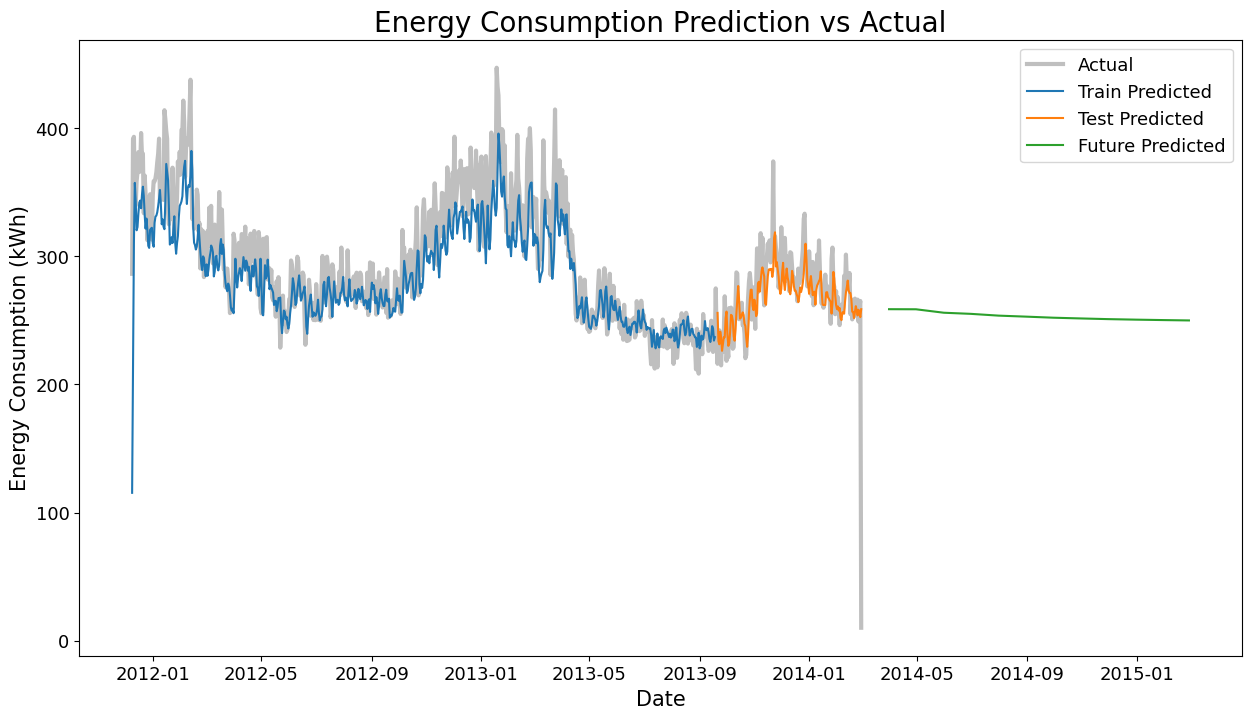

In [31]:
# create an array of future dates
future_dates = pd.date_range(start=date_values.iloc[-1], periods=13, freq='M')[1:]

# plot the data
plt.figure(figsize=(15, 8))
plt.plot(date_values[look_back:], scaler.inverse_transform(scaled_values)[look_back:], label='Actual', 
         color='grey', linewidth=3, alpha = 0.5)
plt.plot(date_values[look_back:len(trainPredict)+look_back], trainPredict, label='Train Predicted')
plt.plot(date_values[len(trainPredict)+(look_back*2):], testPredict, label='Test Predicted')
plt.plot(future_dates, future_predictions, label='Future Predicted')
plt.title('Energy Consumption Prediction vs Actual', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Energy Consumption (kWh)', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.show()
